<a href="https://colab.research.google.com/github/eoinleen/Biophysics-general/blob/main/Dianthus_ratio_fitting_v7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*** SPECTRAL SHIFT ASSAY CONFIGURATION ***
Target protein concentration: 50.0 nM (5.00e-08 M)
Plotting mode: All data on single graphs
Dianthus Binding Analysis Tool (Enhanced with Spectral Shift Models)
NEW FEATURES:
   • Spectral shift models for 670nm/650nm ratiometric data
   • Accounts for protein depletion and 1:1 stoichiometry
   • Enhanced color/symbol coding for multi-pair visualization
   • Set your target protein concentration at the top of the script
Upload your Excel file with:
   • Column A: Concentration in nM
   • Column B: 670nm/650nm ratio values
   • Zero concentrations will be automatically handled


Saving 110287_all.xlsx to 110287_all (2).xlsx
File '110287_all (2).xlsx' uploaded successfully!
File structure preview:
   Rows: 13
   Columns: [45388, 0.947863071780617, '45388.1', 0.9490313783454084, '45388.2', 0.9355361211957889]

First few rows:
          45388  0.947863       45388.1  0.949031       45388.2  0.935536
0  15129.333333  0.967209  15129.333333  0.936924  15129.333333  0.952230
1   5043.111111  1.008085   5043.111111  0.994880   5043.111111  0.987096
2   1681.037037  1.044872   1681.037037  1.062902   1681.037037  1.045282
3    560.345679  1.207306    560.345679  1.186365    560.345679  1.181778
4    186.781893  1.270803    186.781893  1.287269    186.781893  1.288377

Found 3 column pairs:
   Pair 0: 45388 (conc nM) & 0.947863071780617 (ratio 670/650nm)
   Pair 1: 45388.1 (conc nM) & 0.9490313783454084 (ratio 670/650nm)
   Pair 2: 45388.2 (conc nM) & 0.9355361211957889 (ratio 670/650nm)

Analysis plan:
   Pairs to fit: [0, 1, 2]
   All pairs will be fitted (no scatter

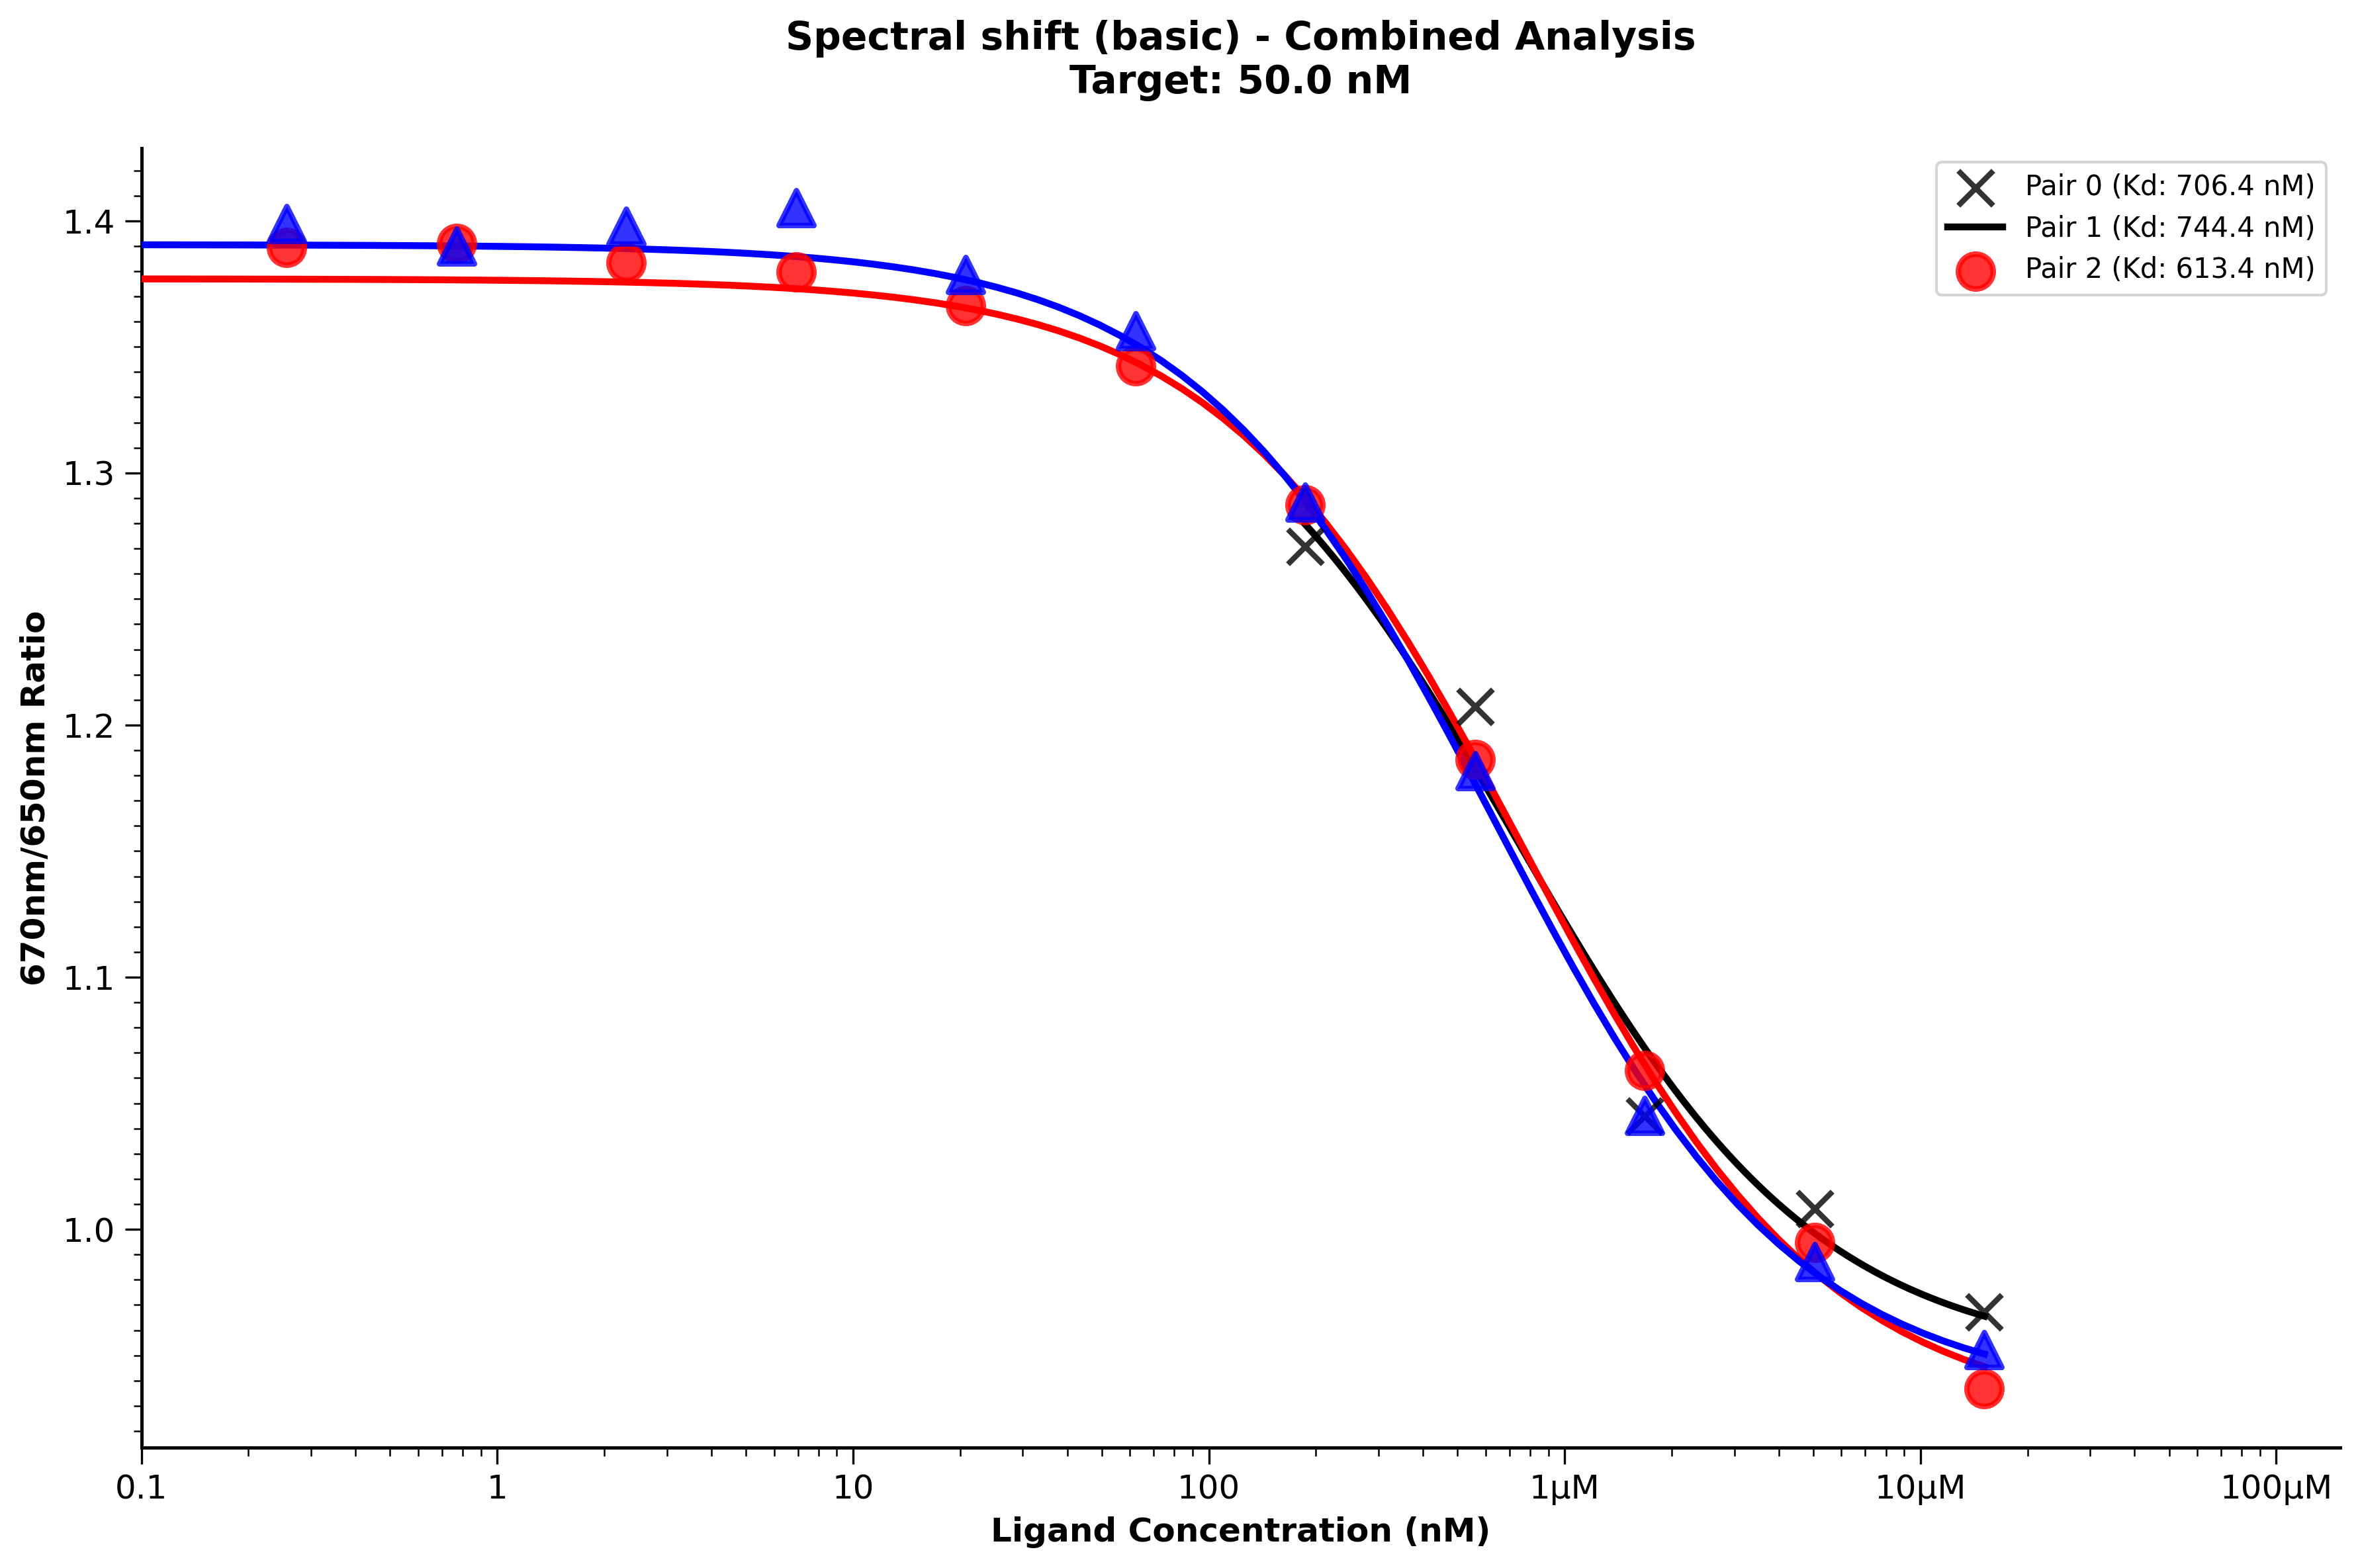

Saved: Dianthus_combined_One_site_decrease.png


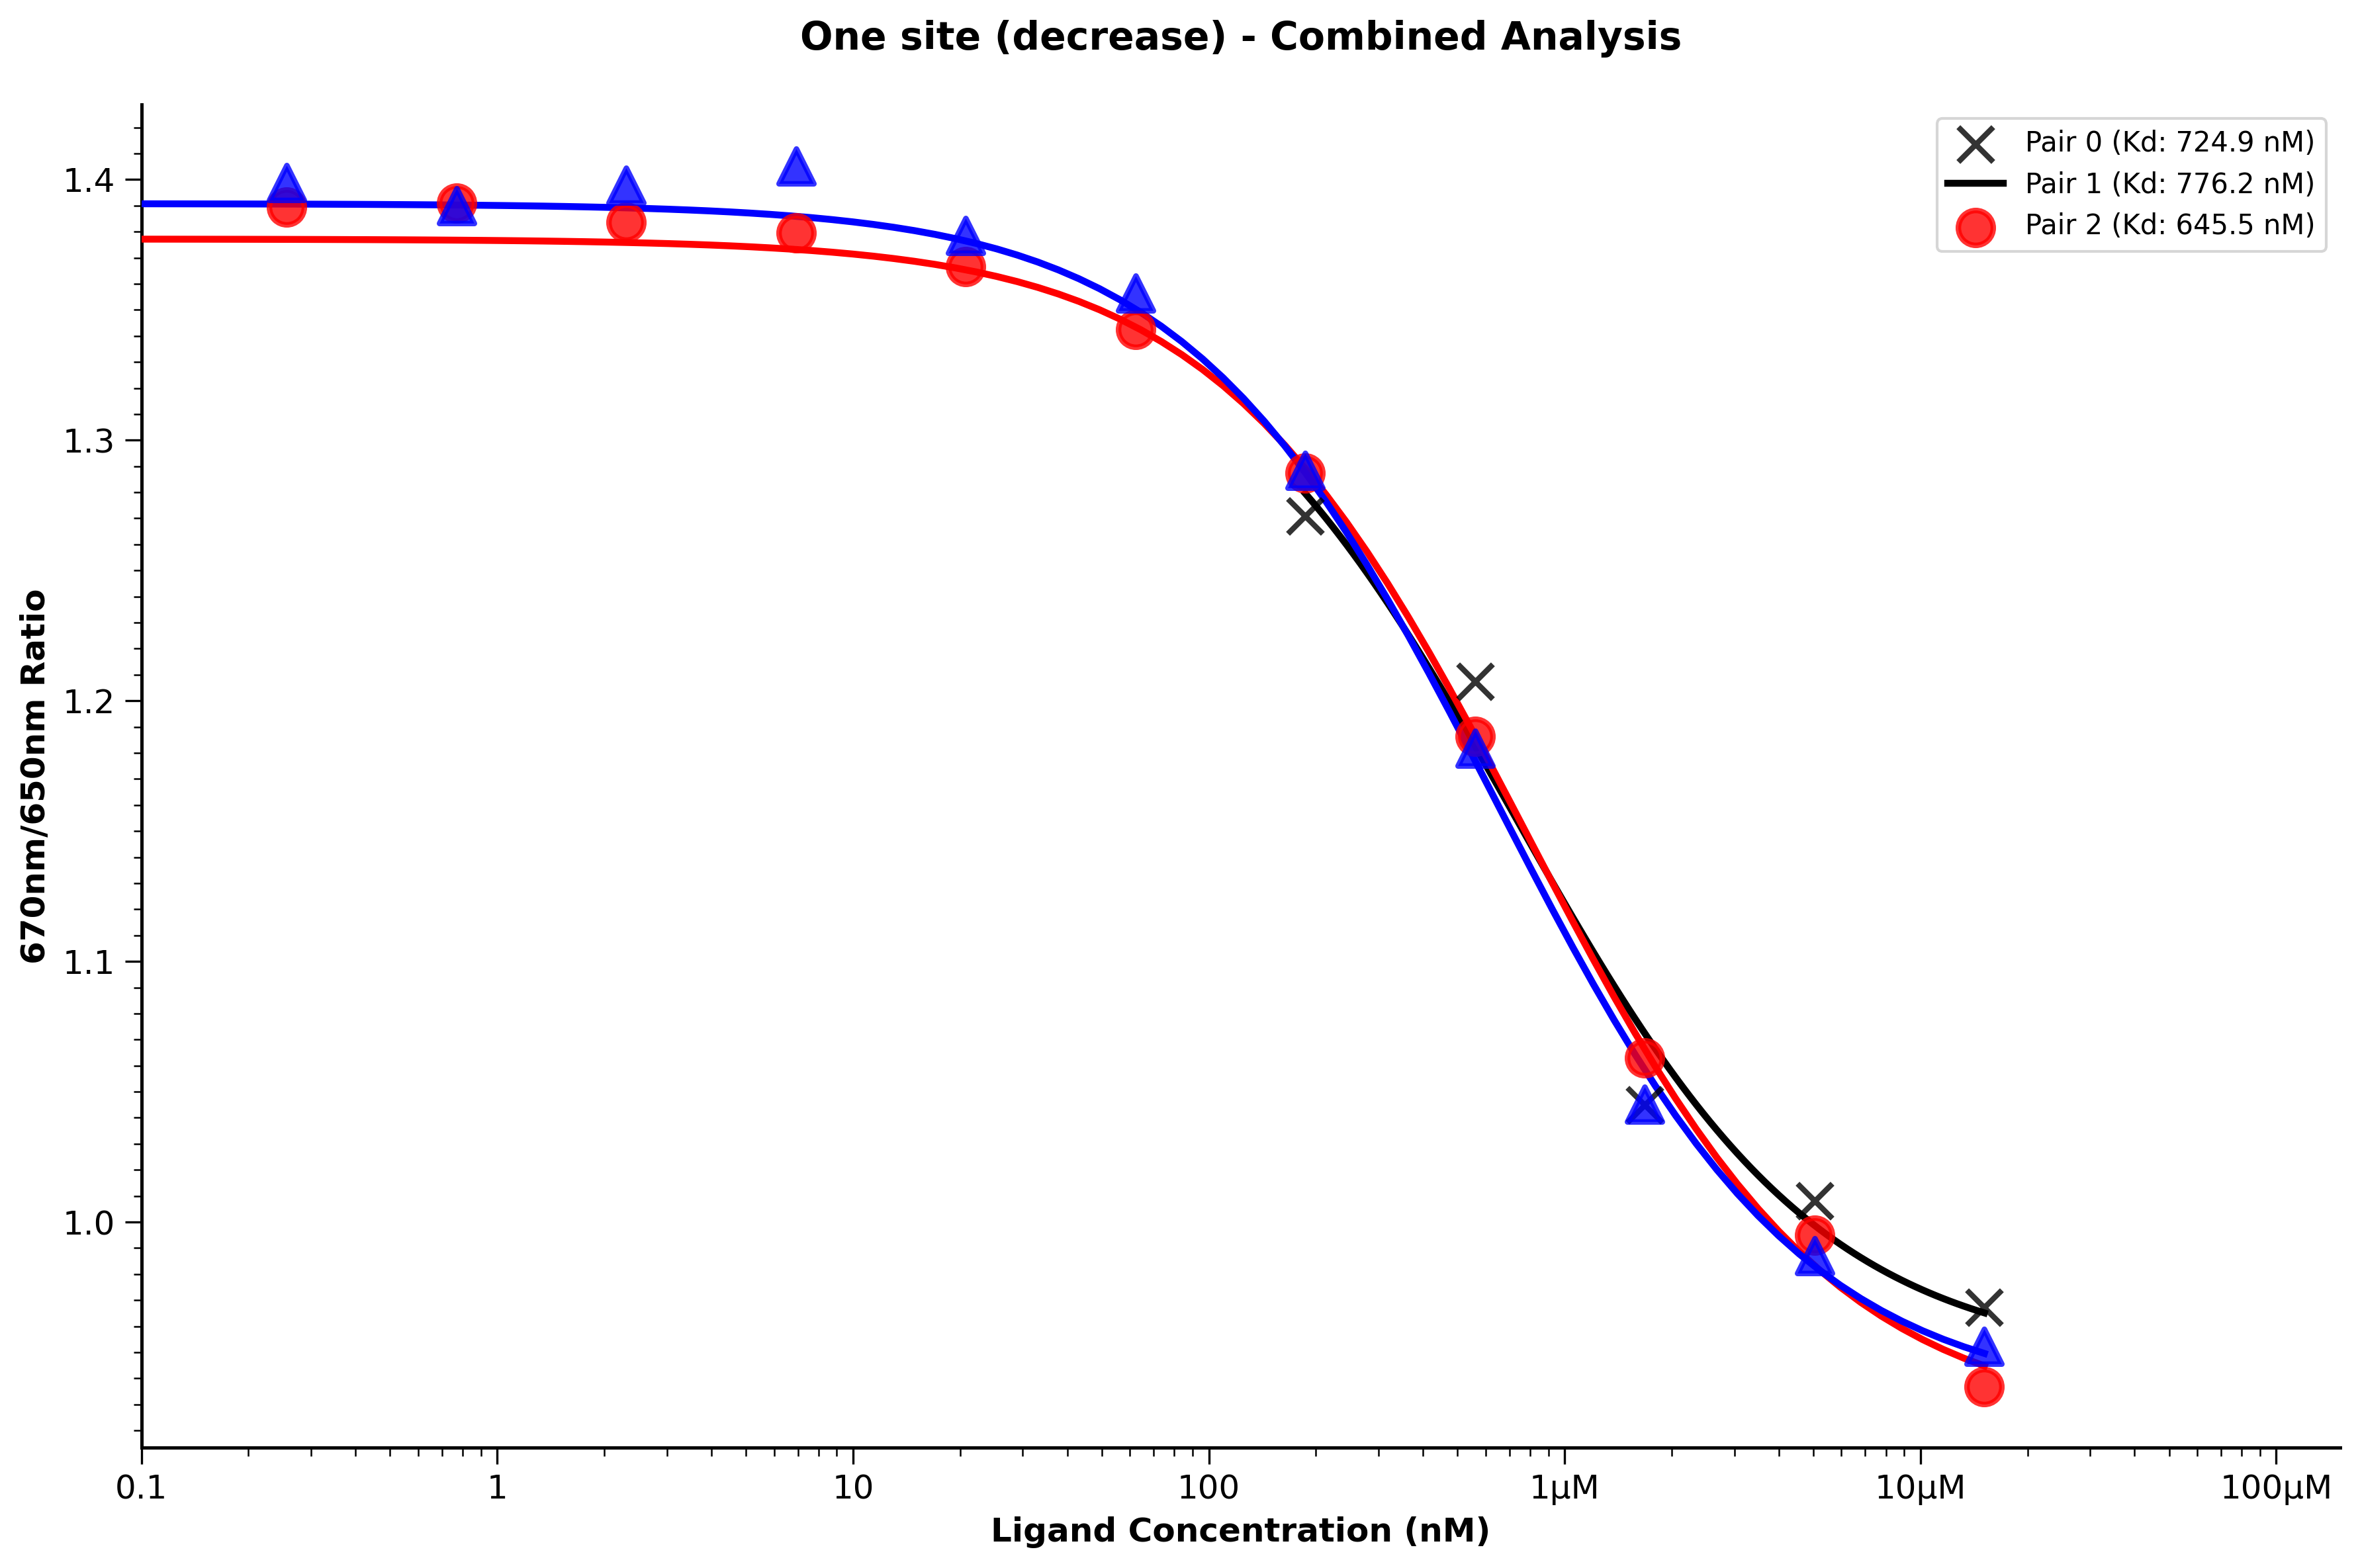

Saved: Dianthus_combined_Hill_equation.png


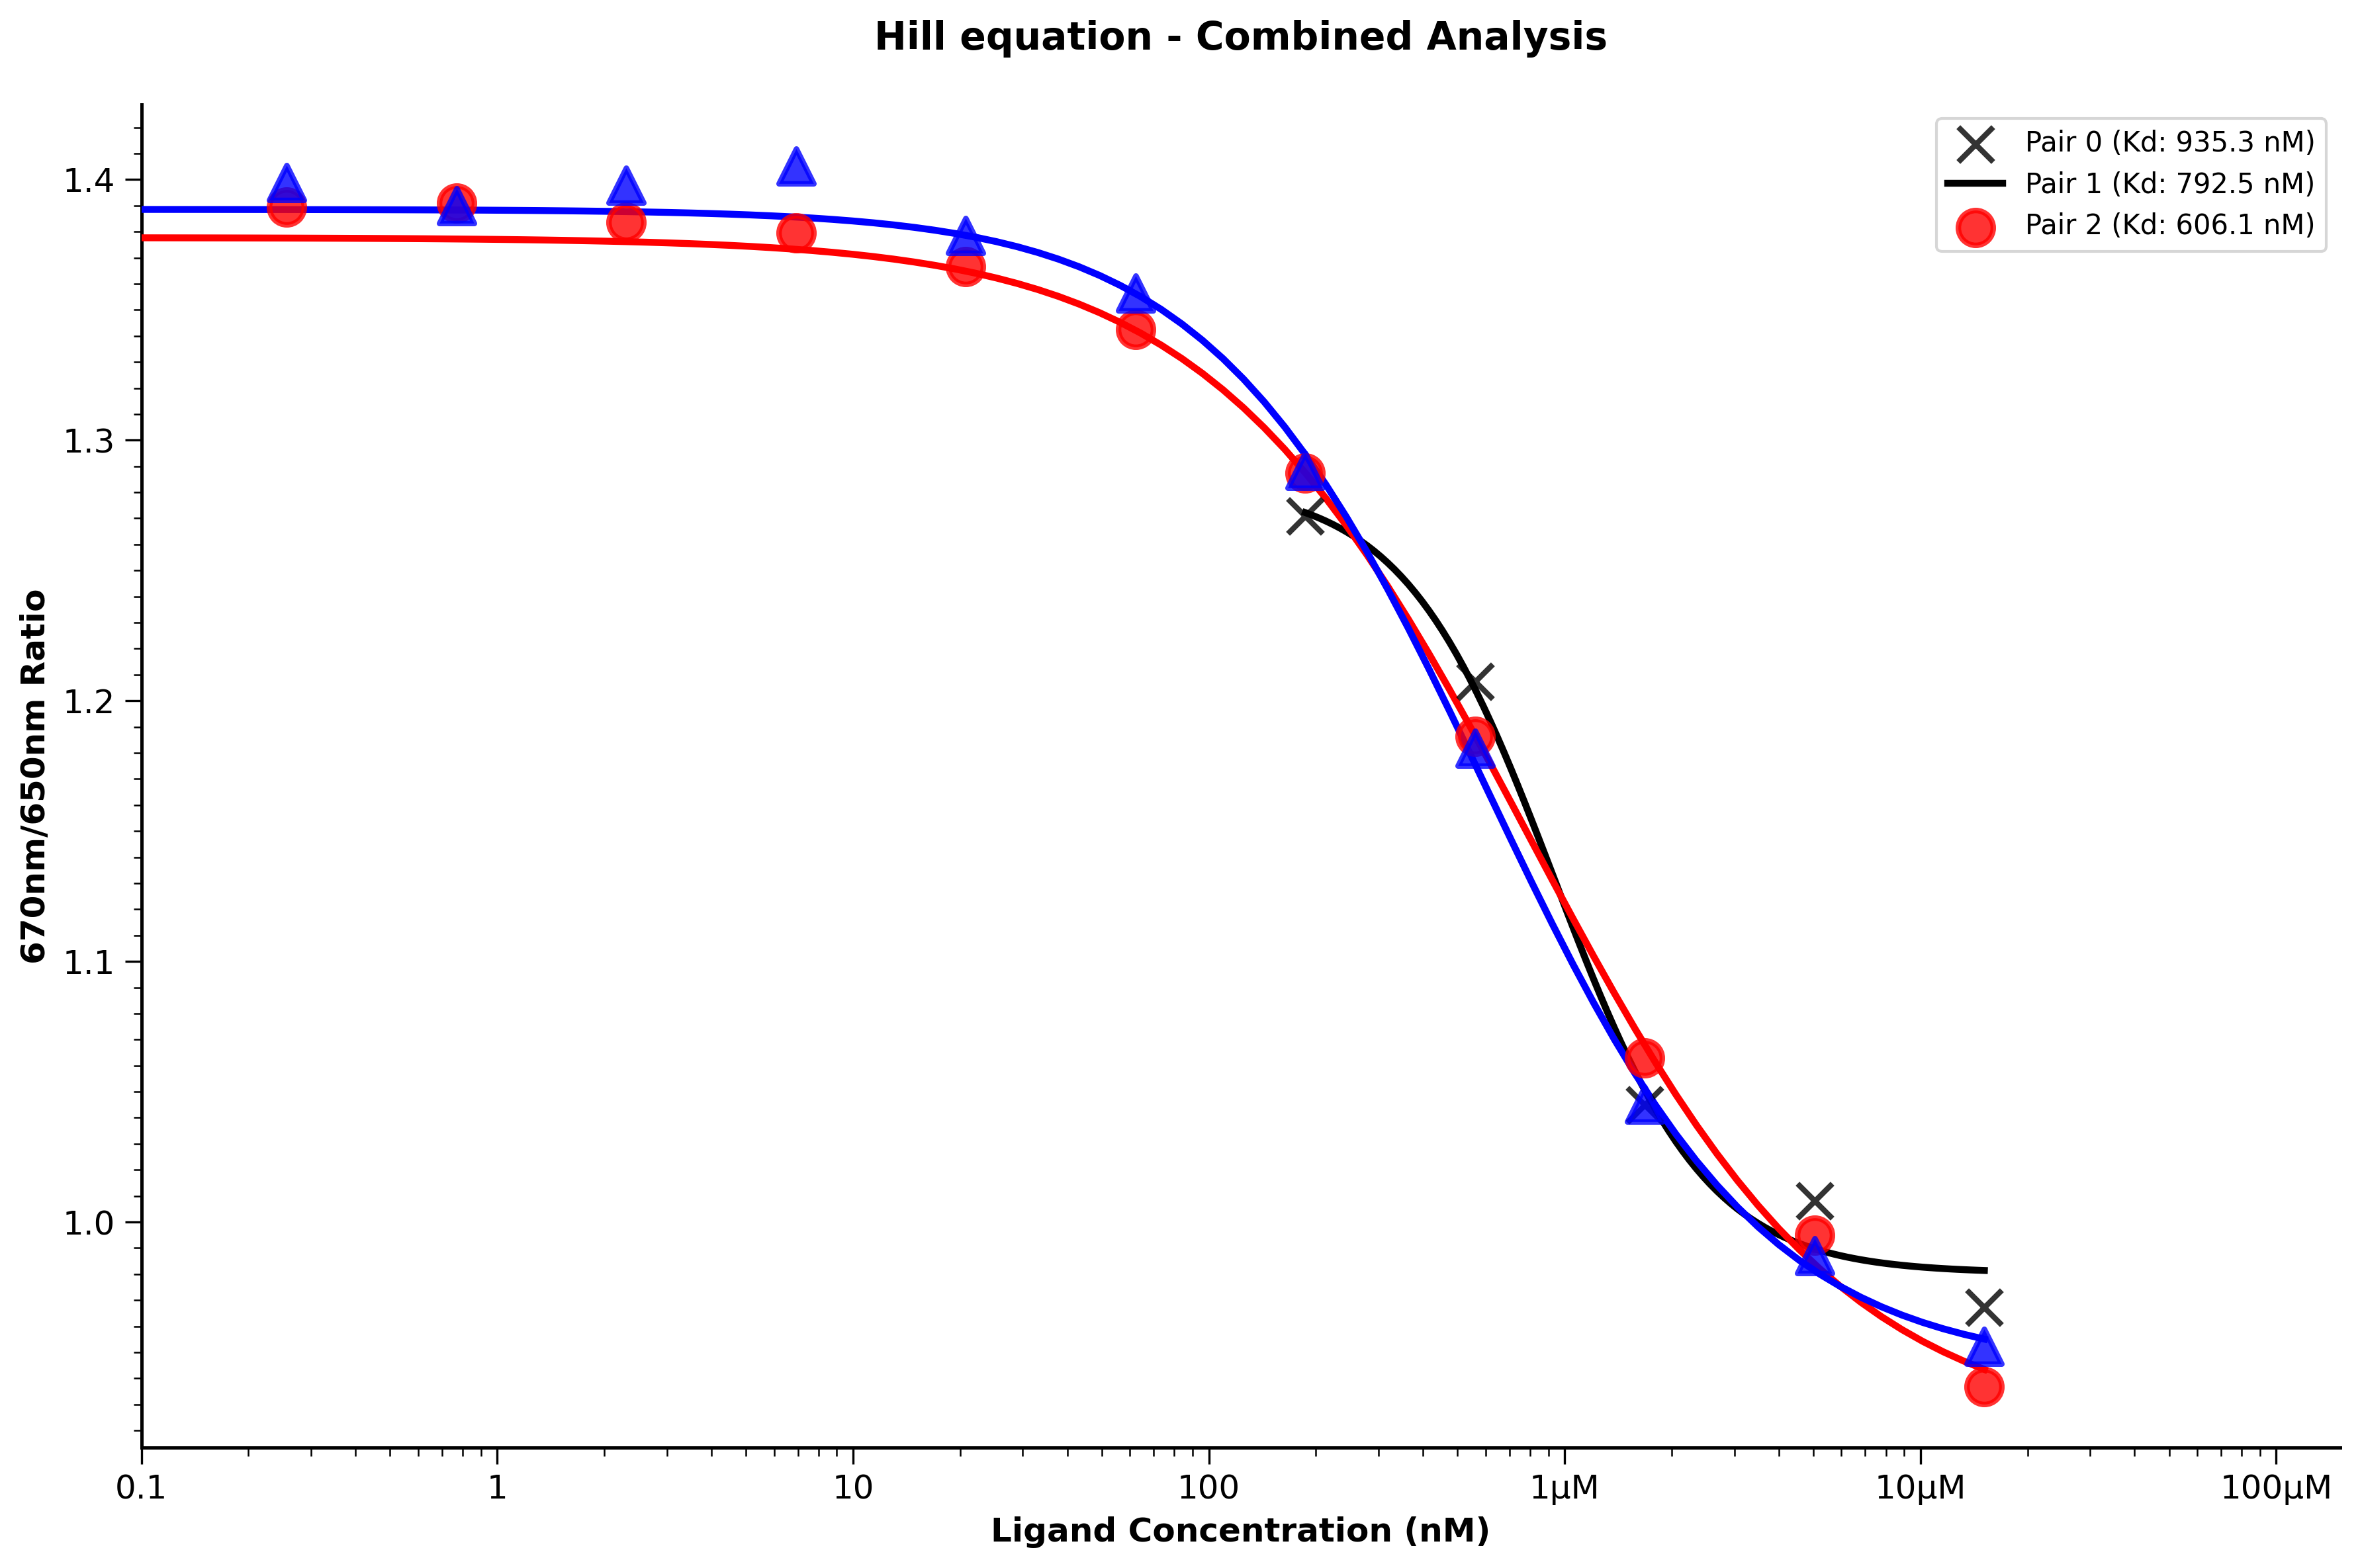

Saved: Dianthus_combined_One_site_plus_non-specific.png


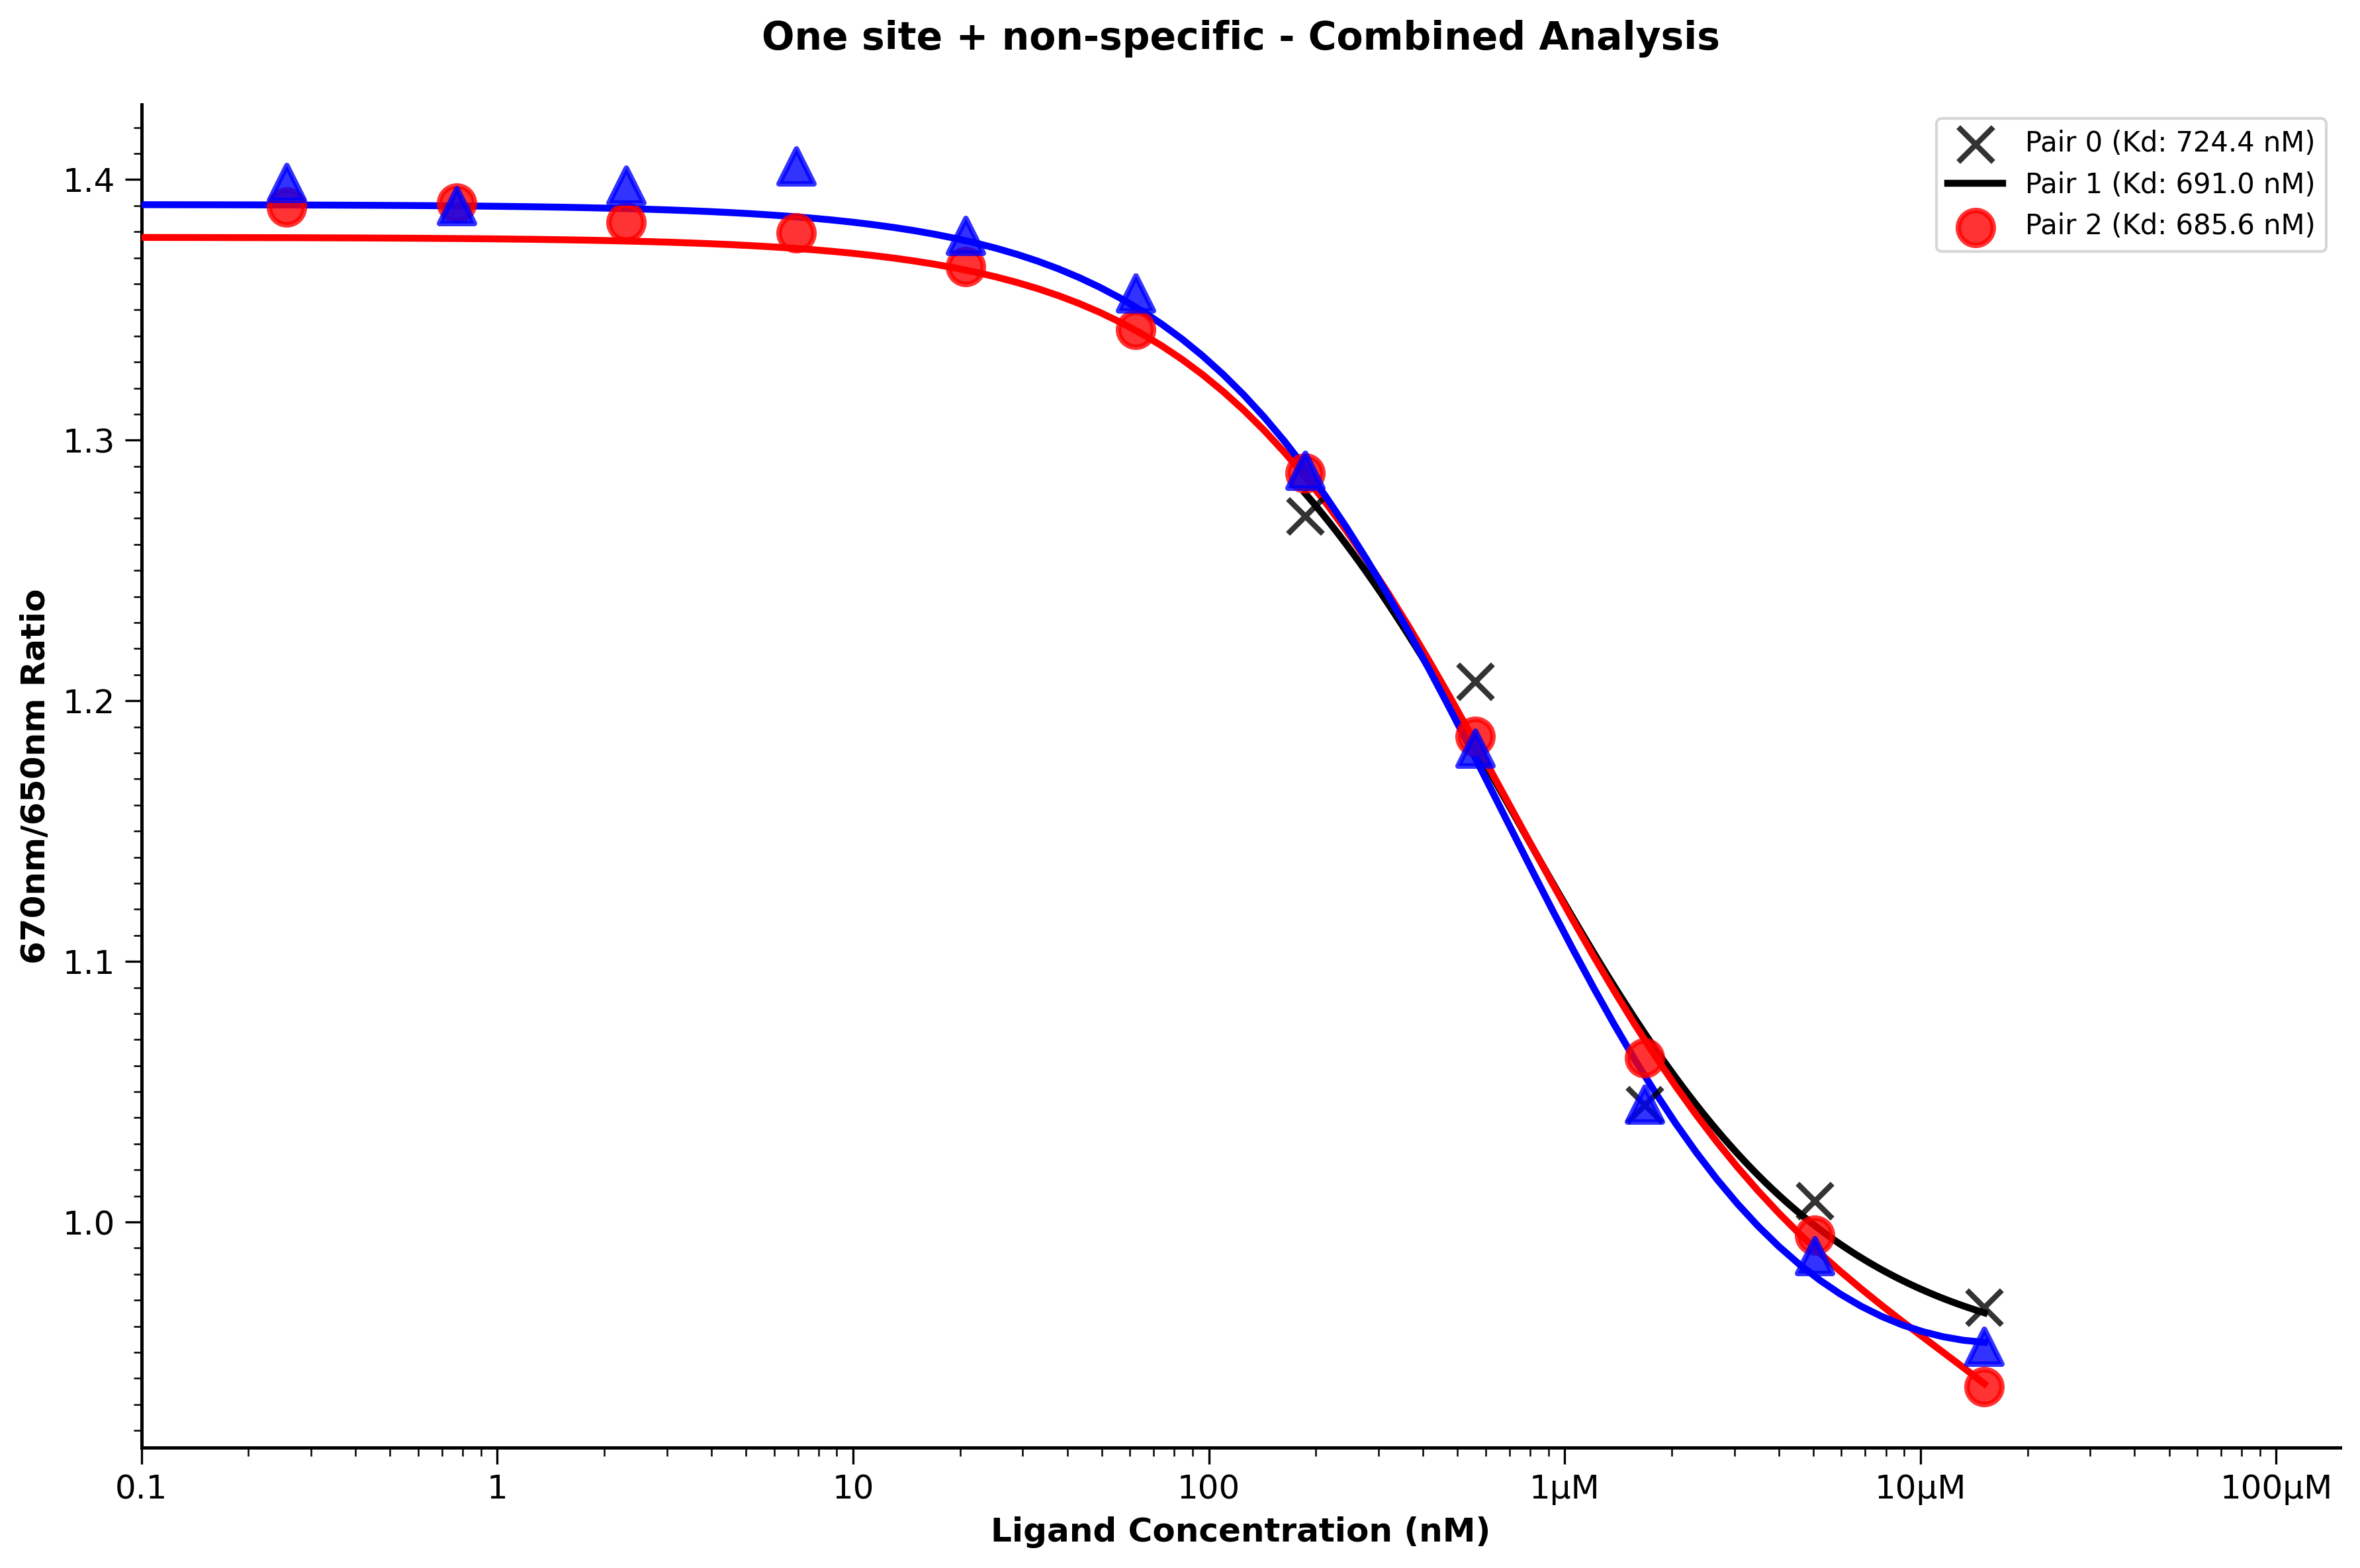

In [3]:
"""
Dianthus Binding Assay Analysis Script (Bidirectional Signal + Spectral Shift) - Enhanced Version
====================================================================================================

Author: Claude (Anthropic) with ChatGPT5 robustness improvements + Spectral Shift Integration
Version: 4.0
Date: 2025

OVERVIEW:
This script analyzes Dianthus binding assay data where the signal can either increase
or decrease upon ligand binding. Now includes spectral shift models for ratiometric
fluorescence measurements (670nm/650nm ratios). Unlike TRIC assays, this modality
allows for both positive and negative signal changes depending on the binding mechanism.

INPUT DATA FORMAT:
- Excel files with paired columns: (A,B), (C,D), (E,F), etc.
- Column pattern: Concentration (nM), Ratio values (670nm/650nm)
- Ratio can increase or decrease from baseline upon binding

================================================================================
FLUORESCENT PROTEIN CONCENTRATION SECTION
================================================================================
"""

# *** FLUORESCENT PROTEIN CONCENTRATION SECTION ***
# Set your target protein concentration here (this remains constant throughout the assay)
TARGET_PROTEIN_CONCENTRATION_NM = 50.0  # nM - MODIFY THIS VALUE FOR YOUR ASSAY
TARGET_PROTEIN_CONCENTRATION_M = TARGET_PROTEIN_CONCENTRATION_NM * 1e-9  # Converted to M

# *** PLOTTING OPTIONS SECTION ***
# Set to True to plot all data pairs on single graphs per model (overlay mode)
# Set to False to create separate plots for each pair/model combination
PLOT_ALL_DATA_ON_SINGLE_GRAPH = True  # True/False - MODIFY THIS FOR YOUR PREFERENCE

print(f"*** SPECTRAL SHIFT ASSAY CONFIGURATION ***")
print(f"Target protein concentration: {TARGET_PROTEIN_CONCENTRATION_NM} nM ({TARGET_PROTEIN_CONCENTRATION_M:.2e} M)")
print(f"Plotting mode: {'All data on single graphs' if PLOT_ALL_DATA_ON_SINGLE_GRAPH else 'Separate plots per pair'}")
print("=" * 60)

"""
================================================================================
MATHEMATICAL MODELS AND FITTING ALGORITHM
================================================================================

BINDING MODELS TESTED:
1. ONE SITE BINDING (Increase):
   Y = Bottom + (Top - Bottom) × X/(Kd + X)
   For signals that increase with binding concentration

2. ONE SITE BINDING (Decrease):
   Y = Top - (Top - Bottom) × X/(Kd + X)
   For signals that decrease with binding concentration

3. ONE SITE BINDING WITH NON-SPECIFIC:
   Y = Bottom + (Top - Bottom) × X/(Kd + X) + NS × X
   Includes linear non-specific component

4. HILL EQUATION (Bidirectional):
   Y = Bottom + (Top - Bottom) / (1 + (Kd/X)^n)
   Can handle both increases and decreases with Hill coefficient

5. BASIC SPECTRAL SHIFT (Kd Model):
   R(C_ligand) = R_unbound + f(C_ligand) × (R_bound - R_unbound)
   where f(C_ligand) = (C_ligand + C_target + Kd - √((C_ligand + C_target + Kd)² - 4×C_ligand×C_target)) / (2×C_target)

   This model accounts for:
   - 1:1 stoichiometry according to law of mass action
   - Protein depletion at high binding affinity (uses TARGET_PROTEIN_CONCENTRATION)
   - Ratiometric readout normalization

SPECTRAL SHIFT DATA ANALYSIS:
Data fitting employs Levenberg-Marquardt optimization to compare five binding models:
classical one-site binding (increase/decrease), one-site with non-specific binding,
Hill equation, and basic spectral shift model.

The basic spectral shift model uses R(C_ligand) = R_unbound + f(C_ligand) × (R_bound - R_unbound)
with 1:1 stoichiometry accounting for protein depletion. Model selection uses AICc
(small sample corrected Akaike Information Criterion) with AIC and R² as fallbacks.
Parameter errors derive from covariance matrix diagonals, with 95% confidence intervals
assuming normal distribution. Target protein concentration remains constant at
TARGET_PROTEIN_CONCENTRATION_NM for accurate depletion calculations.

SPECTRAL SHIFT MODEL NOT IMPLEMENTED:
6. SPECTRAL SHIFT WITH 650nm CORRECTION:
   R(C_ligand) = [R_unbound + f(C_ligand) × (R_bound × r - R_unbound)] / [1 + f(C_ligand) × (r - 1)]
   where r = F_bound / F_unbound

   This enhanced model corrects for ligand-induced fluorescence changes at 650nm but requires
   raw fluorescence intensity data (F_bound, F_unbound) that is not available in standard
   Dianthus exports. The Dianthus software can implement this correction because it has
   access to individual channel intensities, but exported data typically contains only
   pre-calculated 670/650nm ratios. Attempting to fit the r_factor parameter without the
   underlying intensity data would be mathematically unsound.

================================================================================
FITTING ALGORITHM DETAILS
================================================================================
Algorithm: Levenberg-Marquardt (LM) non-linear least squares optimization
Implementation: SciPy curve_fit function

The Levenberg-Marquardt algorithm combines:
- Gauss-Newton method: Fast convergence near the solution
- Gradient descent: Stable convergence far from solution
- Adaptive damping parameter (λ) that adjusts during iteration

Optimization Process:
1. Initial parameter estimates generated from data characteristics
2. Zero/negative concentrations safely handled (dropped or clamped)
3. Iterative parameter adjustment to minimize sum of squared residuals
4. Parameter bounds enforced to ensure physically meaningful results
5. Maximum 5000 iterations allowed for convergence
6. Covariance matrix calculated from Jacobian at convergence

SPECTRAL SHIFT SPECIFIC CONSIDERATIONS:
- Target protein concentration held constant for protein depletion calculations
- Fraction bound calculation uses exact quadratic formula solution
- Physical bounds enforced (0 ≤ f_bound ≤ 1) to prevent unphysical solutions
- Model accounts for high-affinity binding where ligand depletion occurs

================================================================================
MODEL SELECTION
================================================================================
Primary: AICc (corrected Akaike Information Criterion) for small samples
Fallback: AIC (Akaike Information Criterion)
Final fallback: R² (coefficient of determination)

AICc = AIC + 2k(k+1)/(n-k-1) where:
- n = number of data points
- k = number of parameters
- Penalizes overfitting more heavily than R² alone

The AICc correction becomes important when n/k < 40, which is common in binding assays.
Spectral shift models are compared against classical binding models using identical
selection criteria to ensure fair model comparison.

================================================================================
ERROR ANALYSIS AND STATISTICS
================================================================================
Parameter Standard Errors:
- Calculated as √(diagonal elements of covariance matrix)
- Robust handling of ill-conditioned covariance matrices
- NaN values returned when covariance is invalid
- Bootstrap option available for non-parametric confidence intervals

Confidence Intervals:
- 90% CI: parameter ± 1.645 × standard_error
- 95% CI: parameter ± 1.96 × standard_error
- Negative bounds reported as "<detection limit"
- Based on normal distribution assumption (bootstrap available as alternative)

SPECTRAL SHIFT SPECIFIC STATISTICS:
- Kd values reported in both M and nM units
- pKd calculated as -log10(Kd) when appropriate
- Protein concentration effects on confidence intervals noted
- Relative error assessment includes spectral shift model considerations

================================================================================
ROBUSTNESS IMPROVEMENTS
================================================================================
- Zero/negative concentration handling with multiple strategies
- Graceful degradation when covariance matrix is singular
- Comprehensive exception handling with meaningful error messages
- Automatic fallback between model selection criteria
- Safe parameter error calculation with bounds checking
- Spectral shift model bounds enforcement for physical realism
- Enhanced color and symbol cycling for multi-pair visualization

================================================================================
LIMITATIONS AND WARNINGS
================================================================================
- Negative confidence interval bounds indicate poor parameter identifiability
- High relative errors (>30%) suggest insufficient data quality or range
- Parameter correlation can lead to unreliable individual parameter estimates
- Assumes homoscedastic (constant variance) residuals
- Large confidence intervals may require log-normal distribution assumptions
- Spectral shift models require accurate target protein concentration input
- 650nm correction model cannot be implemented with standard export data
- Protein aggregation or labeling heterogeneity can affect spectral shift results

================================================================================
RECOMMENDED DATA QUALITY CRITERIA
================================================================================
- Signal change >20% for reliable fitting
- Concentration range spanning 0.1× to 10× the expected Kd
- Clear baseline and saturation plateaus
- Signal-to-noise ratio >3:1
- Minimum 8-10 data points across the binding curve
- For spectral shift: ensure target concentration is accurately known
- For high-affinity interactions: include concentrations well below target concentration
- Verify labeling efficiency and protein stability throughout assay

================================================================================
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import sys
import traceback
from google.colab import files
import numpy.random as npr

# Set minimalist plotting style with Helvetica font
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica', 'Arial', 'DejaVu Sans'],
    'axes.linewidth': 1.2,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'xtick.major.size': 6,
    'ytick.major.size': 6,
    'axes.grid': False,
    'figure.facecolor': 'none',
    'axes.facecolor': 'none'
})

# Color and symbol schemes for multi-pair plotting
BASE_COLORS = ['black', 'red', 'blue', 'green', 'orange']
LIGHT_COLORS = ['gray', 'lightcoral', 'lightblue', 'lightgreen', 'moccasin']
SYMBOLS = ['x', 'o', '^', 's', '*']

def get_pair_style(pair_idx):
    """Return color and symbol for a given pair index"""
    color_idx = pair_idx % 5
    symbol_idx = pair_idx % 5

    if pair_idx < 5:
        color = BASE_COLORS[color_idx]
    else:
        color = LIGHT_COLORS[color_idx]

    symbol = SYMBOLS[symbol_idx]
    return color, symbol

# Robust helper functions
def safe_param_errors(pcov):
    """Return parameter standard errors, handling invalid pcov gracefully."""
    if pcov is None:
        return None
    try:
        diag = np.diag(pcov)
        diag = np.clip(diag, 0, np.inf)
        se = np.sqrt(diag)
        se[~np.isfinite(se)] = np.nan
        return se
    except Exception:
        return None

def aic_from_residuals(n, ss_res, k):
    """AIC (Akaike Information Criterion)."""
    if n <= 0:
        return np.nan, np.nan
    try:
        aic = n * np.log(ss_res / n) + 2 * k
        if n - k - 1 > 0:
            aicc = aic + (2 * k * (k + 1)) / (n - k - 1)
        else:
            aicc = np.nan
        return aic, aicc
    except Exception:
        return np.nan, np.nan

def _prepare_nonzero_conc(conc, ratios, min_positive=1e-12, drop_zeros=True):
    """Return conc_nonzero (M) and ratios arrays safe for log operations."""
    conc = np.asarray(conc, dtype=float)
    ratios = np.asarray(ratios, dtype=float)
    mask = np.isfinite(conc) & np.isfinite(ratios)
    conc = conc[mask]
    ratios = ratios[mask]
    if drop_zeros:
        good = conc > 0
        if not np.any(good):
            conc = np.clip(conc, min_positive, None)
            return conc, ratios
        return conc[good], ratios[good]
    else:
        conc = np.clip(conc, min_positive, None)
        return conc, ratios

def bootstrap_param_cis(func, x, y, popt, n_boot=500, random_seed=0):
    """Residual bootstrap around fit (non-parametric)."""
    npr.seed(random_seed)
    residuals = y - func(x, *popt)
    boot_params = []
    n = len(y)
    for _ in range(n_boot):
        resampled_res = npr.choice(residuals, size=n, replace=True)
        y_boot = func(x, *popt) + resampled_res
        try:
            popt_boot, _ = curve_fit(func, x, y_boot, p0=popt, maxfev=5000)
            boot_params.append(popt_boot)
        except Exception:
            continue
    boot_params = np.array(boot_params)
    if boot_params.size == 0:
        return None
    cis = {}
    for i in range(boot_params.shape[1]):
        cis[i] = (np.percentile(boot_params[:, i], 2.5), np.percentile(boot_params[:, i], 97.5))
    return cis

# Original model functions
def one_site_binding_increase(x, bottom, top, kd):
    """One site binding with signal increase"""
    return bottom + (top - bottom) * x / (kd + x)

def one_site_binding_decrease(x, top, bottom, kd):
    """One site binding with signal decrease"""
    return top - (top - bottom) * x / (kd + x)

def one_site_binding_ns(x, bottom, top, kd, ns):
    """One site binding with non-specific component"""
    return bottom + (top - bottom) * x / (kd + x) + ns * x

def hill_equation_bidirectional(x, bottom, top, kd, hill_coeff):
    """Hill equation that can handle increases or decreases"""
    return bottom + (top - bottom) / (1 + (kd / x) ** hill_coeff)

# Spectral shift model functions
def fraction_bound_spectral_shift(c_ligand, kd, c_target):
    """
    Calculate fraction bound using spectral shift Kd model (1:1 stoichiometry).
    Accounts for protein depletion at high binding affinity.

    Parameters:
    c_ligand: ligand concentration (M)
    kd: dissociation constant (M)
    c_target: target protein concentration (M)
    """
    # Quadratic formula solution for 1:1 binding with mass action
    term = c_ligand + c_target + kd
    sqrt_term = np.sqrt(term**2 - 4 * c_ligand * c_target)
    f_bound = (term - sqrt_term) / (2 * c_target)
    return np.clip(f_bound, 0, 1)  # Ensure physically meaningful bounds

def spectral_shift_basic(x, r_unbound, r_bound, kd):
    """
    Basic spectral shift model for ratiometric readouts.
    R(C_ligand) = R_unbound + f(C_ligand) × (R_bound - R_unbound)
    """
    f_bound = fraction_bound_spectral_shift(x, kd, TARGET_PROTEIN_CONCENTRATION_M)
    return r_unbound + f_bound * (r_bound - r_unbound)

def analyze_binding_data(concentrations, ratios, verbose=True):
    """
    Enhanced fitting wrapper with spectral shift models.
    """
    try:
        # Sort by concentration
        concentrations = np.asarray(concentrations, dtype=float)
        ratios = np.asarray(ratios, dtype=float)
        sort_idx = np.argsort(concentrations)
        conc_sorted = concentrations[sort_idx]
        ratio_sorted = ratios[sort_idx]

        # Prepare data for fitting
        conc_for_fit, ratio_for_fit = _prepare_nonzero_conc(conc_sorted, ratio_sorted, drop_zeros=True)

        if len(conc_for_fit) < 4:
            if verbose:
                print("   Warning: Not enough non-zero data points for reliable fitting (need >=4).")

        # Determine signal direction
        signal_increases = ratio_sorted[-1] > ratio_sorted[0]
        if verbose:
            print(f"   Signal direction: {'Increases' if signal_increases else 'Decreases'} with concentration")

        models_to_test = []

        # Helper function to safely attempt a fit
        def try_fit(func, p0, bounds=(-np.inf, np.inf), param_names=None, kd_index=2, model_name="Unknown"):
            try:
                popt, pcov = curve_fit(func, conc_for_fit, ratio_for_fit, p0=p0, bounds=bounds, maxfev=5000)
                fitted = func(conc_for_fit, *popt)
                ss_res = np.sum((ratio_for_fit - fitted) ** 2)
                ss_tot = np.sum((ratio_for_fit - np.mean(ratio_for_fit)) ** 2)
                r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan
                n = len(conc_for_fit)
                k = len(popt)
                aic, aicc = aic_from_residuals(n, ss_res, k)
                se = safe_param_errors(pcov)
                models_to_test.append({
                    'name': model_name,
                    'params': popt,
                    'pcov': pcov,
                    'param_errors': se,
                    'param_names': param_names,
                    'r2': r2,
                    'ss_res': ss_res,
                    'ss_tot': ss_tot,
                    'n': n,
                    'k': k,
                    'aic': aic,
                    'aicc': aicc,
                    'fitted': fitted,
                    'function': func,
                    'kd_index': kd_index,
                    'equation': get_equation_string(model_name)
                })
                if verbose:
                    print(f"   Fitted {model_name} (k={k}) — R²={r2:.4f}, AIC={aic:.2f}")
                return True
            except Exception as e:
                if verbose:
                    print(f"   Fit failed for {model_name}: {e}")
                return False

        # ORIGINAL MODELS (Models 1-4)
        # Model 1: One site increase
        if signal_increases:
            bottom = np.nanmin(ratio_sorted)
            top = np.nanmax(ratio_sorted)
            kd_guess = np.median(conc_for_fit) if len(conc_for_fit) else 1e-9
            p0 = [bottom, top, kd_guess]
            bounds = ([0, 0, 1e-12], [np.inf, np.inf, np.inf])
            try_fit(one_site_binding_increase, p0, bounds=bounds,
                   param_names=['Bottom','Top','Kd (M)'], kd_index=2,
                   model_name='One site (increase)')

        # Model 2: One site decrease
        if not signal_increases:
            top = np.nanmax(ratio_sorted)
            bottom = np.nanmin(ratio_sorted)
            kd_guess = np.median(conc_for_fit) if len(conc_for_fit) else 1e-9
            p0 = [top, bottom, kd_guess]
            bounds = ([0, 0, 1e-12], [np.inf, np.inf, np.inf])
            try_fit(one_site_binding_decrease, p0, bounds=bounds,
                   param_names=['Top','Bottom','Kd (M)'], kd_index=2,
                   model_name='One site (decrease)')

        # Model 3: One site + NS
        if signal_increases:
            p0 = [np.nanmin(ratio_sorted), np.nanmax(ratio_sorted), np.median(conc_for_fit), 0.0]
        else:
            p0 = [np.nanmax(ratio_sorted), np.nanmin(ratio_sorted), np.median(conc_for_fit), 0.0]
        bounds = ([0, 0, 1e-12, -np.inf], [np.inf, np.inf, np.inf, np.inf])
        try_fit(one_site_binding_ns, p0, bounds=bounds,
               param_names=['Bottom','Top','Kd (M)','NS'], kd_index=2,
               model_name='One site + non-specific')

        # Model 4: Hill (bidirectional)
        if signal_increases:
            p0 = [np.nanmin(ratio_sorted), np.nanmax(ratio_sorted), np.median(conc_for_fit), 1.0]
        else:
            p0 = [np.nanmax(ratio_sorted), np.nanmin(ratio_sorted), np.median(conc_for_fit), 1.0]
        bounds = ([0, 0, 1e-12, 0.1], [np.inf, np.inf, np.inf, 5.0])
        try_fit(hill_equation_bidirectional, p0, bounds=bounds,
               param_names=['Bottom','Top','Kd (M)','Hill'], kd_index=2,
               model_name='Hill equation')

        # Model 5: Basic spectral shift
        r_unbound_guess = ratio_sorted[0]  # Baseline ratio
        r_bound_guess = ratio_sorted[-1]   # Saturated ratio
        kd_guess = np.median(conc_for_fit) if len(conc_for_fit) else 1e-9

        p0 = [r_unbound_guess, r_bound_guess, kd_guess]
        bounds = ([0, 0, 1e-12], [np.inf, np.inf, np.inf])
        try_fit(spectral_shift_basic, p0, bounds=bounds,
               param_names=['R_unbound','R_bound','Kd (M)'], kd_index=2,
               model_name='Spectral shift (basic)')

        if not models_to_test:
            if verbose:
                print("   No models succeeded.")
            return None

        # Choose best model by AICc (if available) else AIC else R²
        valid_models = [m for m in models_to_test if np.isfinite(m.get('aicc', np.nan))]
        if valid_models:
            best = min(valid_models, key=lambda m: m['aicc'])
            selection_method = "AICc"
        else:
            valid_models = [m for m in models_to_test if np.isfinite(m.get('aic', np.nan))]
            if valid_models:
                best = min(valid_models, key=lambda m: m['aic'])
                selection_method = "AIC"
            else:
                best = max(models_to_test, key=lambda m: m.get('r2', -np.inf))
                selection_method = "R²"

        # Prepare smooth curve
        min_c = np.min(conc_for_fit)
        max_c = np.max(conc_for_fit)
        if min_c <= 0:
            min_c = np.min(np.clip(conc_for_fit, 1e-12, None))
        conc_smooth = np.logspace(np.log10(min_c), np.log10(max_c), 200)

        # Evaluate
        smooth_vals = best['function'](conc_smooth, *best['params'])

        if verbose:
            print(f"\n   Model comparison (sorted by {selection_method}):")
            for model in sorted(models_to_test, key=lambda x: x.get('aicc', x.get('aic', -x.get('r2', 0)))):
                aicc_str = f"AICc={model['aicc']:.2f}" if np.isfinite(model.get('aicc', np.nan)) else "AICc=n/a"
                print(f"   {model['name']}: R²={model['r2']:.4f}, {aicc_str}")
            print(f"   Best model: {best['name']} (selected by {selection_method})")

        # Assemble return dict
        result = {
            'parameters': best['params'],
            'param_errors': best.get('param_errors', None),
            'param_names': best.get('param_names', None),
            'r2': best.get('r2', np.nan),
            'method': best['name'],
            'equation': best.get('equation', ''),
            'original_conc': conc_sorted,
            'original_ratios': ratio_sorted,
            'smooth_conc': conc_smooth,
            'smooth_ratios': smooth_vals,
            'all_models': models_to_test,
            'kd_index': best.get('kd_index', 2),
            'aic': best.get('aic', np.nan),
            'aicc': best.get('aicc', np.nan),
            'selection_method': selection_method
        }

        return result

    except Exception as e:
        print("Fitting failed:", e)
        traceback.print_exc(limit=3, file=sys.stdout)
        return None

def get_equation_string(model_name):
    """Return equation string for model name"""
    equations = {
        'One site (increase)': 'Y = Bottom + (Top-Bottom)*X/(Kd+X)',
        'One site (decrease)': 'Y = Top - (Top-Bottom)*X/(Kd+X)',
        'One site + non-specific': 'Y = Bottom + (Top-Bottom)*X/(Kd+X) + NS*X',
        'Hill equation': 'Y = Bottom + (Top-Bottom)/(1+(Kd/X)^n)',
        'Spectral shift (basic)': 'R = R_unbound + f(C) × (R_bound - R_unbound)'
    }
    return equations.get(model_name, 'Unknown equation')

def show_confidence_intervals_with_warnings(result, pair_idx, verbose=True):
    """Safely report Kd, CIs and pKd; gracefully handle invalid/missing values."""
    if result is None:
        print(f"   No fit result for pair {pair_idx}.")
        return

    params = result.get('parameters')
    errors = result.get('param_errors')
    kd_idx = result.get('kd_index', 2)

    if params is None or kd_idx >= len(params):
        print("   Kd not available in parameter vector.")
        return

    kd_m = params[kd_idx]
    kd_err = None
    if errors is not None and len(errors) > kd_idx:
        kd_err = errors[kd_idx]

    # Basic checks
    if not np.isfinite(kd_m) or kd_m <= 0:
        print(f"   Invalid Kd estimate: {kd_m}. Cannot compute pKd or meaningful CIs.")
        return

    kd_nm = kd_m * 1e9
    print(f"   Kd: {kd_m:.3e} M ({kd_nm:.1f} nM)")

    # Add spectral shift specific information
    method_name = result.get('method', '')
    if 'Spectral shift' in method_name:
        print(f"   Target concentration used: {TARGET_PROTEIN_CONCENTRATION_NM} nM")

    if kd_err is None or not np.isfinite(kd_err):
        print("   Standard error: unavailable (pcov invalid). Consider bootstrap.")
    else:
        kd_err_nm = kd_err * 1e9
        print(f"   Standard Error: ± {kd_err:.3e} M (± {kd_err_nm:.1f} nM)")

        # CIs
        ci90_low = kd_m - 1.645 * kd_err
        ci90_high = kd_m + 1.645 * kd_err
        ci95_low = kd_m - 1.96 * kd_err
        ci95_high = kd_m + 1.96 * kd_err

        def fmt_ci(low, high):
            if not np.isfinite(low) or not np.isfinite(high):
                return "n/a"
            low_nm = low * 1e9
            high_nm = high * 1e9
            if low_nm < 0:
                return f"<detection limit - {high_nm:.1f} nM (lower bound negative)"
            return f"{low_nm:.1f} - {high_nm:.1f} nM"

        print(f"   90% CI: {fmt_ci(ci90_low, ci90_high)}")
        ci95_formatted = fmt_ci(ci95_low, ci95_high)
        print(f"   95% CI: {ci95_formatted}")

        # Provide publication suggestion for negative CIs
        if ci95_low * 1e9 < 0:
            ci95_upper_nm = ci95_high * 1e9
            print(f"   Publication format: Kd = {kd_nm:.0f} nM (95% CI: below detection limit to {ci95_upper_nm:.0f} nM)")

    # pKd
    try:
        pkd = -np.log10(kd_m)
        print(f"   pKd: {pkd:.2f}")
    except Exception:
        print("   pKd: n/a (invalid Kd for log)")

    # Relative error with quality assessment
    if kd_err is not None and np.isfinite(kd_err):
        rel_err_pct = (kd_err / kd_m) * 100
        print(f"   Relative error: {rel_err_pct:.1f}% ", end="")
        if rel_err_pct > 50:
            print("(POOR - >50%)")
        elif rel_err_pct > 30:
            print("(MODERATE - >30%)")
        elif rel_err_pct > 15:
            print("(ACCEPTABLE - >15%)")
        else:
            print("(GOOD - <15%)")
    else:
        print("   Relative error: n/a (no stderr)")

def analyze_uploaded_file_multi(filename, pairs_to_fit=None, pairs_to_plot=None):
    """
    Load and analyze multiple column pairs from Excel file
    """
    try:
        # Read Excel file
        df = pd.read_excel(filename, engine='openpyxl')

        print(f"File structure preview:")
        print(f"   Rows: {len(df)}")
        print(f"   Columns: {list(df.columns)}")
        print("\nFirst few rows:")
        print(df.head())

        # Determine number of column pairs
        n_cols = df.shape[1]
        n_pairs = n_cols // 2

        print(f"\nFound {n_pairs} column pairs:")
        for i in range(n_pairs):
            col_names = df.columns[i*2:(i+1)*2].tolist()
            print(f"   Pair {i}: {col_names[0]} (conc nM) & {col_names[1]} (ratio 670/650nm)")

        # Set defaults if not specified - now fit ALL pairs by default
        if pairs_to_fit is None:
            pairs_to_fit = list(range(n_pairs))  # Fit all pairs
        if pairs_to_plot is None:
            pairs_to_plot = []  # No scatter-only pairs by default

        print(f"\nAnalysis plan:")
        print(f"   Pairs to fit: {pairs_to_fit}")
        if pairs_to_plot:
            print(f"   Pairs to plot as scatter: {pairs_to_plot}")
        else:
            print("   All pairs will be fitted (no scatter-only data)")

        # Extract and analyze data
        all_data = {}
        fit_results = {}

        for pair_idx in range(n_pairs):
            conc_col = pair_idx * 2
            ratio_col = pair_idx * 2 + 1

            concentrations_nm = df.iloc[:, conc_col].dropna().values
            ratios = df.iloc[:, ratio_col].dropna().values

            # Match lengths
            min_len = min(len(concentrations_nm), len(ratios))
            concentrations_nm = concentrations_nm[:min_len]
            ratios = ratios[:min_len]

            # Convert to M for calculations (but keep nM for display)
            concentrations_m = concentrations_nm * 1e-9

            all_data[pair_idx] = {
                'conc_nm': concentrations_nm,
                'conc_m': concentrations_m,
                'ratios': ratios,
                'name': f"Pair {pair_idx}"
            }

            print(f"\nPair {pair_idx} data summary:")
            print(f"   Data points: {len(concentrations_m)}")
            print(f"   Concentration range: {np.min(concentrations_nm):.1f} - {np.max(concentrations_nm):.1f} nM")
            print(f"   Ratio range: {np.min(ratios):.3f} - {np.max(ratios):.3f}")

        # Fit specified pairs
        if pairs_to_fit:
            print(f"\nFitting {len(pairs_to_fit)} pairs...")
            for pair_idx in pairs_to_fit:
                if pair_idx < n_pairs:
                    print(f"\n--- Analyzing Pair {pair_idx} ---")
                    result = analyze_binding_data(all_data[pair_idx]['conc_m'],
                                                all_data[pair_idx]['ratios'])
                    if result:
                        fit_results[pair_idx] = result
                        kd_nm = result['parameters'][result['kd_index']] * 1e9
                        selection_method = result.get('selection_method', 'R²')
                        print(f"Best fit: {result['method']} - Kd: {kd_nm:.1f} nM, R²: {result['r2']:.3f} (selected by {selection_method})")

                        # Show confidence intervals with warnings
                        show_confidence_intervals_with_warnings(result, pair_idx)

        # Create combined plot
        plot_all_models(all_data, fit_results, pairs_to_fit, pairs_to_plot)

        return all_data, fit_results

    except Exception as e:
        print(f"Error loading file '{filename}': {e}")
        traceback.print_exc(limit=3, file=sys.stdout)
        return None, None

def plot_all_models(all_data, fit_results, pairs_to_fit, pairs_to_plot):
    """Create plots for each binding model - either combined or separate based on user preference"""

    if PLOT_ALL_DATA_ON_SINGLE_GRAPH:
        # Combined plotting mode - one graph per model showing all fitted pairs
        plot_combined_models(all_data, fit_results, pairs_to_fit, pairs_to_plot)
    else:
        # Separate plotting mode - individual plots for each pair/model combination
        plot_separate_models(all_data, fit_results, pairs_to_fit, pairs_to_plot)

def plot_combined_models(all_data, fit_results, pairs_to_fit, pairs_to_plot):
    """Create combined plots showing all data pairs on single graphs per model"""

    # Get all unique model names from all fitted results
    all_model_names = set()
    for pair_idx in pairs_to_fit:
        if pair_idx in fit_results and 'all_models' in fit_results[pair_idx]:
            for model in fit_results[pair_idx]['all_models']:
                all_model_names.add(model['name'])

    # Create one plot for each unique model
    for model_name in all_model_names:
        fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=300)
        fig.patch.set_alpha(0)
        ax.patch.set_alpha(0)

        legend_entries = []

        # Plot fitted pairs for this model
        for pair_idx in pairs_to_fit:
            if pair_idx in fit_results and 'all_models' in fit_results[pair_idx]:
                result = fit_results[pair_idx]
                data = all_data[pair_idx]

                # Find the specific model for this pair
                model = None
                for m in result['all_models']:
                    if m['name'] == model_name:
                        model = m
                        break

                if model is None:
                    continue

                # Get color and symbol for this pair
                fitted_color, fitted_symbol = get_pair_style(pair_idx)

                # Plot data points
                ax.scatter(data['conc_nm'], data['ratios'],
                          alpha=0.8, s=160, color=fitted_color,
                          marker=fitted_symbol, linewidths=2, zorder=5)

                # Generate and plot smooth curve
                conc_smooth = np.logspace(np.log10(np.min(data['conc_nm'][data['conc_nm']>0])),
                                         np.log10(np.max(data['conc_nm'])), 100)
                conc_smooth_m = conc_smooth * 1e-9
                smooth_curve = model['function'](conc_smooth_m, *model['params'])

                ax.plot(conc_smooth, smooth_curve,
                       color=fitted_color, linewidth=2.5, zorder=3)

                # Add to legend
                kd_nm = model['params'][model.get('kd_index', 2)] * 1e9
                legend_entries.append(f"Pair {pair_idx} (Kd: {kd_nm:.1f} nM)")

        # Plot scatter-only pairs if any
        for scatter_pair_idx in pairs_to_plot:
            if scatter_pair_idx in all_data:
                scatter_data = all_data[scatter_pair_idx]
                scatter_color, scatter_symbol = get_pair_style(scatter_pair_idx)

                if scatter_symbol == 'x':
                    scatter_marker = 'x'
                    facecolor = scatter_color
                    edgecolor = scatter_color
                else:
                    scatter_marker = scatter_symbol
                    facecolor = 'none'
                    edgecolor = scatter_color

                ax.scatter(scatter_data['conc_nm'], scatter_data['ratios'],
                          alpha=0.8, s=120, facecolors=facecolor,
                          edgecolors=edgecolor, marker=scatter_marker,
                          linewidths=1.5, zorder=5)

                legend_entries.append(f"Pair {scatter_pair_idx} (data only)")

        # Styling
        ax.set_xscale('log')
        ax.set_xlabel('Ligand Concentration (nM)', fontsize=12, fontweight='bold')
        ax.set_ylabel('670nm/650nm Ratio', fontsize=12, fontweight='bold')
        ax.tick_params(labelsize=12, which='major', direction='out', length=6)
        ax.tick_params(which='minor', direction='out', length=3)

        # Add minor ticks
        from matplotlib.ticker import AutoMinorLocator
        ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))

        # Set axis limits based on all data
        all_conc_nm = []
        for pair_idx in list(pairs_to_fit) + pairs_to_plot:
            if pair_idx in all_data:
                pair_conc = all_data[pair_idx]['conc_nm']
                all_conc_nm.extend(pair_conc[pair_conc > 0])

        if all_conc_nm:
            data_min = np.min(all_conc_nm)
            data_max = np.max(all_conc_nm)

            tick_start = 1 if data_min >= 1 else 0.1
            tick_end = max(10000, data_max * 10) if data_max > 1000 else 10000
            ax.set_xlim(tick_start, tick_end)

        from matplotlib.ticker import FuncFormatter
        def format_func_nm(x, pos):
            if x >= 1000:
                return f'{x/1000:g}µM'
            else:
                return f'{x:g}'
        ax.xaxis.set_major_formatter(FuncFormatter(format_func_nm))

        # Add title
        title = f"{model_name} - Combined Analysis"
        if 'Spectral shift' in model_name:
            title += f"\nTarget: {TARGET_PROTEIN_CONCENTRATION_NM} nM"
        ax.set_title(title, fontsize=14, fontweight='bold', pad=20)

        # Add legend
        if legend_entries:
            ax.legend(legend_entries, fontsize=10, loc='best')

        plt.tight_layout()

        # Save file
        model_name_clean = model_name.replace(' ', '_').replace('(', '').replace(')', '').replace('+', 'plus')
        filename = f'Dianthus_combined_{model_name_clean}'

        try:
            plt.savefig(f'{filename}.png', dpi=300, bbox_inches='tight',
                       transparent=True, facecolor='none')
            print(f"Saved: {filename}.png")
        except Exception as e:
            print(f"PNG save failed: {e}")

        plt.show()

def plot_separate_models(all_data, fit_results, pairs_to_fit, pairs_to_plot):
    """Create separate plots for each pair/model combination"""

    for pair_idx in pairs_to_fit:
        if pair_idx in fit_results and 'all_models' in fit_results[pair_idx]:
            result = fit_results[pair_idx]
            data = all_data[pair_idx]

            # Create separate plots for each model
            for i, model in enumerate(result['all_models']):
                fig, ax = plt.subplots(1, 1, figsize=(10, 7), dpi=300)
                fig.patch.set_alpha(0)
                ax.patch.set_alpha(0)

                # Get color and symbol for fitted data pair
                fitted_color, fitted_symbol = get_pair_style(pair_idx)

                # Plot fitted data points
                ax.scatter(data['conc_nm'], data['ratios'],
                          alpha=0.8, s=160, color=fitted_color,
                          marker=fitted_symbol, linewidths=2, zorder=5,
                          label=f"Pair {pair_idx} (fitted)")

                # Generate smooth curve for this model
                conc_smooth = np.logspace(np.log10(np.min(data['conc_nm'][data['conc_nm']>0])),
                                         np.log10(np.max(data['conc_nm'])), 100)
                conc_smooth_m = conc_smooth * 1e-9

                smooth_curve = model['function'](conc_smooth_m, *model['params'])

                # Plot fitted curve with same color as data
                ax.plot(conc_smooth, smooth_curve,
                       color=fitted_color, linewidth=2.5, zorder=3)

                # Plot scatter-only pairs with their own colors and symbols
                for scatter_pair_idx in pairs_to_plot:
                    if scatter_pair_idx in all_data:
                        scatter_data = all_data[scatter_pair_idx]
                        scatter_color, scatter_symbol = get_pair_style(scatter_pair_idx)

                        # Use hollow symbols for scatter-only data
                        if scatter_symbol == 'x':
                            scatter_marker = 'x'
                            facecolor = scatter_color
                            edgecolor = scatter_color
                        else:
                            scatter_marker = scatter_symbol
                            facecolor = 'none'
                            edgecolor = scatter_color

                        ax.scatter(scatter_data['conc_nm'], scatter_data['ratios'],
                                  alpha=0.8, s=120, facecolors=facecolor,
                                  edgecolors=edgecolor, marker=scatter_marker,
                                  linewidths=1.5, zorder=5,
                                  label=f"Pair {scatter_pair_idx} (data only)")

                # Styling
                ax.set_xscale('log')
                ax.set_xlabel('Ligand Concentration (nM)', fontsize=12, fontweight='bold')
                ax.set_ylabel('670nm/650nm Ratio', fontsize=12, fontweight='bold')
                ax.tick_params(labelsize=22, which='major', direction='out', length=6)
                ax.tick_params(which='minor', direction='out', length=3)

                # Add minor ticks
                from matplotlib.ticker import AutoMinorLocator
                ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))

                # X-axis formatting for nM scale with safe range determination
                data_min = np.min(data['conc_nm'][data['conc_nm'] > 0])
                data_max = np.max(data['conc_nm'])

                # Set reasonable tick range based on data
                if data_min >= 1:
                    tick_start = 1
                else:
                    tick_start = 0.1

                if data_max <= 1000:
                    tick_end = 10000
                else:
                    tick_end = max(10000, data_max * 10)

                ax.set_xlim(tick_start, tick_end)

                from matplotlib.ticker import FuncFormatter
                def format_func_nm(x, pos):
                    if x >= 1000:
                        return f'{x/1000:g}µM'
                    else:
                        return f'{x:g}'
                ax.xaxis.set_major_formatter(FuncFormatter(format_func_nm))

                # Add title with model quality indicators
                aicc_str = f", AICc={model['aicc']:.1f}" if np.isfinite(model.get('aicc', np.nan)) else ""
                title = f"{model['name']} (R² = {model['r2']:.4f}{aicc_str})"

                # Add target concentration info for spectral shift models
                if 'Spectral shift' in model['name']:
                    title += f"\nTarget: {TARGET_PROTEIN_CONCENTRATION_NM} nM"

                ax.set_title(title, fontsize=14, fontweight='bold', pad=20)

                # Add legend if multiple pairs are shown
                if pairs_to_plot:
                    ax.legend(fontsize=10, loc='best')

                plt.tight_layout()

                # Save files
                model_name_clean = model['name'].replace(' ', '_').replace('(', '').replace(')', '').replace('+', 'plus')
                filename = f'Dianthus_spectral_shift_{model_name_clean}_pair{pair_idx}'

                try:
                    plt.savefig(f'{filename}.png', dpi=300, bbox_inches='tight',
                               transparent=True, facecolor='none')
                    print(f"Saved: {filename}.png")
                except Exception as e:
                    print(f"PNG save failed: {e}")

                plt.show()

                # Print detailed results with confidence intervals and warnings
                print(f"\n{model['name']}:")
                print(f"   Equation: {model.get('equation', 'N/A')}")
                print(f"   R²: {model['r2']:.4f}")
                if np.isfinite(model.get('aicc', np.nan)):
                    print(f"   AICc: {model['aicc']:.2f}")
                if np.isfinite(model.get('aic', np.nan)):
                    print(f"   AIC: {model['aic']:.2f}")

                # Show all parameters with their names
                if model.get('param_names') and model.get('params') is not None:
                    for param_idx, (name, value) in enumerate(zip(model['param_names'], model['params'])):
                        if 'Kd' in name:
                            value_nm = value * 1e9
                            print(f"   {name}: {value:.3e} M ({value_nm:.1f} nM)")
                        else:
                            print(f"   {name}: {value:.4f}")

                # Show Kd with confidence intervals and error checking
                kd_idx = model.get('kd_index', 2)
                if kd_idx < len(model['params']):
                    kd_m = model['params'][kd_idx]
                    kd_nm = kd_m * 1e9
                    param_error = model.get('param_errors')

                    if param_error is not None and len(param_error) > kd_idx and np.isfinite(param_error[kd_idx]):
                        kd_error_nm = param_error[kd_idx] * 1e9
                        print(f"   Kd Standard Error: ± {param_error[kd_idx]:.3e} M (± {kd_error_nm:.1f} nM)")

                        # Confidence intervals with error checking
                        ci_90_lower_nm = (kd_m - 1.645 * param_error[kd_idx]) * 1e9
                        ci_90_upper_nm = (kd_m + 1.645 * param_error[kd_idx]) * 1e9
                        ci_95_lower_nm = (kd_m - 1.96 * param_error[kd_idx]) * 1e9
                        ci_95_upper_nm = (kd_m + 1.96 * param_error[kd_idx]) * 1e9

                        # Check for negative CIs and warn
                        if ci_90_lower_nm < 0:
                            print(f"   90% CI: <detection limit - {ci_90_upper_nm:.1f} nM (lower bound negative)")
                        else:
                            print(f"   90% CI: ({ci_90_lower_nm:.1f} - {ci_90_upper_nm:.1f} nM)")

                        if ci_95_lower_nm < 0:
                            print(f"   95% CI: <detection limit - {ci_95_upper_nm:.1f} nM (lower bound negative)")
                            print(f"       Publication format: Kd = {kd_nm:.0f} nM (95% CI: below detection limit to {ci_95_upper_nm:.0f} nM)")
                        else:
                            print(f"   95% CI: ({ci_95_lower_nm:.1f} - {ci_95_upper_nm:.1f} nM)")

                        # Relative error assessment
                        relative_error = (param_error[kd_idx] / kd_m) * 100
                        print(f"   Relative error: {relative_error:.1f}%", end="")

                        if relative_error > 50:
                            print(" (POOR)")
                        elif relative_error > 30:
                            print(" (MODERATE)")
                        else:
                            print(" (ACCEPTABLE)")
                    else:
                        print("   Standard Error: unavailable (pcov invalid)")

                # Add spectral shift specific warnings
                if 'Spectral shift' in model['name']:
                    print(f"   Note: Uses target concentration of {TARGET_PROTEIN_CONCENTRATION_NM} nM")

                print("-" * 50)

    print(f"\nAll spectral shift model plots saved for Dianthus binding analysis.")

# Main execution
print("Dianthus Binding Analysis Tool (Enhanced with Spectral Shift Models)")
print("=" * 75)
print("NEW FEATURES:")
print("   • Spectral shift models for 670nm/650nm ratiometric data")
print("   • Accounts for protein depletion and 1:1 stoichiometry")
print("   • Enhanced color/symbol coding for multi-pair visualization")
print("   • Set your target protein concentration at the top of the script")
print("=" * 75)
print("Upload your Excel file with:")
print("   • Column A: Concentration in nM")
print("   • Column B: 670nm/650nm ratio values")
print("   • Zero concentrations will be automatically handled")
print("=" * 75)

# Auto-start
try:
    uploaded = files.upload()

    if uploaded:
        filename = list(uploaded.keys())[0]
        print(f"File '{filename}' uploaded successfully!")

        # Auto-analyze
        data, results = analyze_uploaded_file_multi(filename)
    else:
        print("No file uploaded.")
        print("Manual usage: data, results = analyze_uploaded_file_multi('filename.xlsx')")

except Exception as e:
    print(f"Upload failed: {e}")
    print("For local execution, modify the file upload section.")